In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "/content/drive/MyDrive/aircraft/crop" "/content/dataset"

In [5]:
data_dir = '/content/dataset/'

filepaths = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)

        filepaths.append(fpath)
        labels.append(fold)


data_dir = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
data_dir

,filepaths,labels
0,/content/dataset/F16/04705e0911ce7e3dfebf94037...,F16
1,/content/dataset/F16/a8181fbce35cd6852c73f5426...,F16
2,/content/dataset/F16/68860c002b8727479d3f3c7e5...,F16
3,/content/dataset/F16/c206fa18ae8eff5507078acb4...,F16
4,/content/dataset/F16/483c0e5f489166bd7981b1c26...,F16
...,...,...
18183,/content/dataset/AV8B/3d1c9d4889c20d923acdfb62...,AV8B
18184,/content/dataset/AV8B/3cb7e6c902ccf5977ac1f58d...,AV8B
18185,/content/dataset/AV8B/e1b984e3574a8f5e099ce3e3...,AV8B
18186,/content/dataset/AV8B/1e88f60013b5ee45c71a1f18...,AV8B


In [6]:
train_df, temp_df = train_test_split(data_dir, test_size=0.3, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation & test

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
    color_mode='rgb', class_mode='categorical', batch_size=16
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
    color_mode='rgb', class_mode='categorical', batch_size=16
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
    color_mode='rgb', class_mode='categorical', batch_size=16
)


Found 12731 validated image filenames belonging to 27 classes.
Found 2728 validated image filenames belonging to 27 classes.
Found 2729 validated image filenames belonging to 27 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential

# Load EfficientNetB3 as base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max"
)

# Get the number of classes from the train_gen
num_classes = len(train_gen.class_indices) # Instead of hardcoding as 74 we dynamically fetch it.

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(),

    # Add a Dense layer with Batch Normalization and Dropout
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Use num_classes here
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,190,090 (42.69 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [9]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


In [10]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),  # Reduced from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,190,090 (42.69 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [13]:
# Check this!
assert train_gen.class_indices == valid_gen.class_indices

In [14]:
history=model.fit(train_gen,validation_data=valid_gen,epochs=20)

Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 188s 237ms/step - accuracy: 0.9039 - loss: 0.4903 - val_accuracy: 0.0521 - val_loss: 3.6562
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 190s 238ms/step - accuracy: 0.9150 - loss: 0.4362 - val_accuracy: 0.3098 - val_loss: 2.7841
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 188s 237ms/step - accuracy: 0.9218 - loss: 0.4041 - val_accuracy: 0.2207 - val_loss: 115.9503
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 189s 238ms/step - accuracy: 0.9329 - loss: 0.3549 - val_accuracy: 0.0370 - val_loss: 4.0830
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 188s 236ms/step - accuracy: 0.9367 - loss: 0.3250 - val_accuracy: 0.0301 - val_loss: 4.1366
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 187s 235ms/step - accuracy: 0.9425 - loss: 0.3071 - val_accuracy: 0.8098 - val_loss: 0.8210
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 189s 238ms/step - accuracy: 0.9499 - loss: 0.2806 - val_accuracy: 0.1298 - val_loss: 3.7774
Epoch 8/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 188s 236ms/step - accuracy: 0.9499

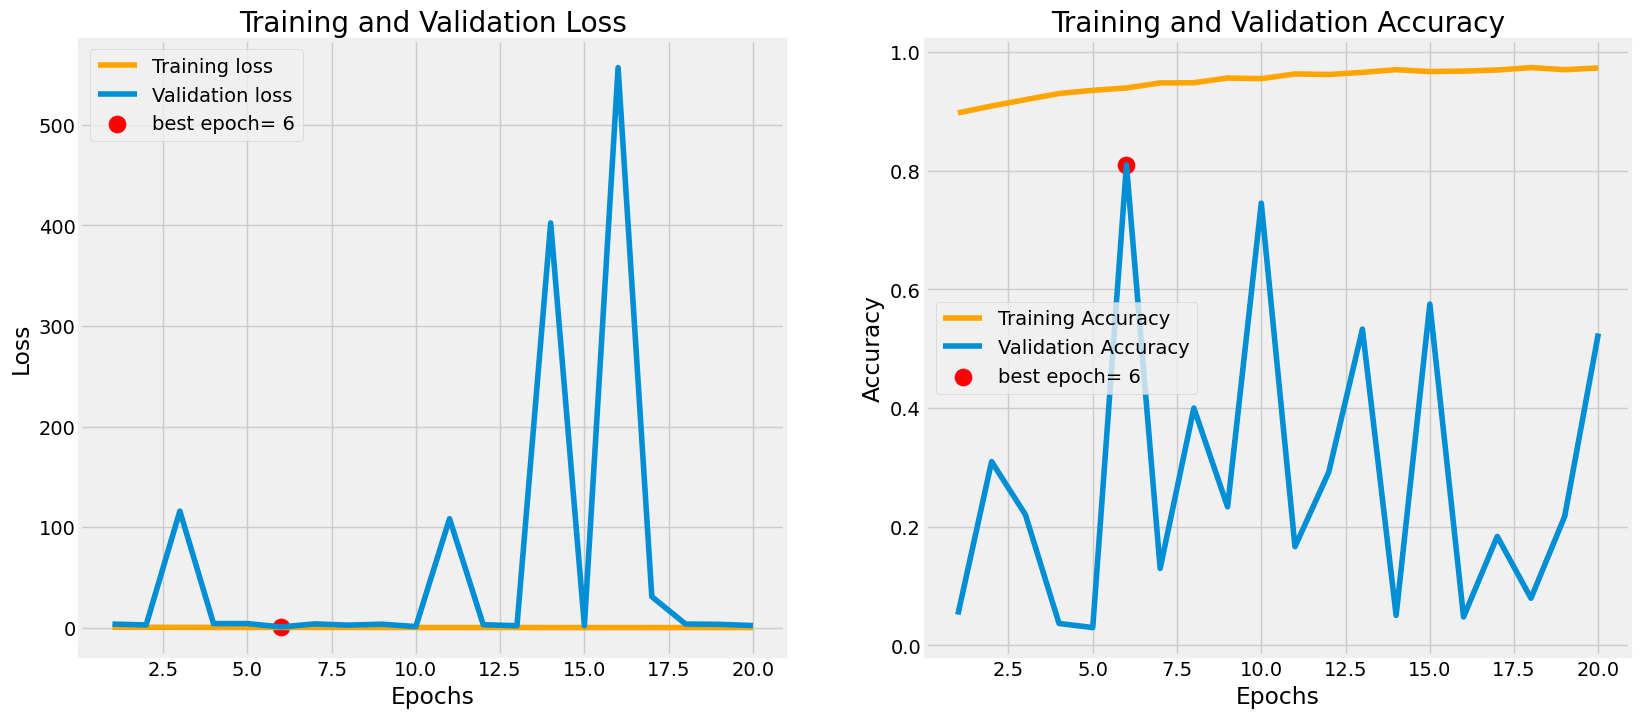

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
# test_score = model.evaluate(test_gen)

pd.DataFrame({
    '': ['Loss','Accuracy'],
    'Train score': [train_score[0], f'{round(train_score[1] * 100, 2)}%'],
#     'Valid score': [valid_score[0], f'{round(valid_score[1] * 100, 2)}%']
    'Test score': [test_score[0], f'{round(test_score[1] * 100, 2)}%']})

796/796 ━━━━━━━━━━━━━━━━━━━━ 182s 229ms/step - accuracy: 0.5279 - loss: 2.0583
  1/171 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.5000 - loss: 2.6550

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5457 - loss: 2.0975


,,Train score,Test score
0,Loss,2.061556,2.148869
1,Accuracy,52.38%,54.09%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,389,522 (127.37 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,199,432 (84.68 MB)

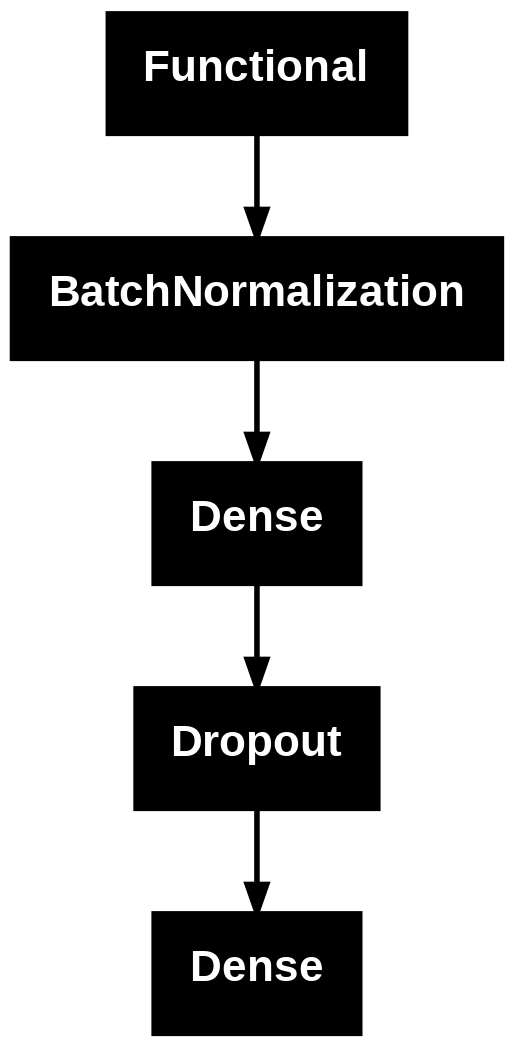

In [17]:
from keras.utils import plot_model
model.summary()
plot_model(model,to_file='model.png')

In [18]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5449 - loss: 2.1698
Test Accuracy: 54.09%


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred_classes already exist
cm = confusion_matrix(y_true, y_pred_classes)

# Plot it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


NameError: name 'y_true' is not defined

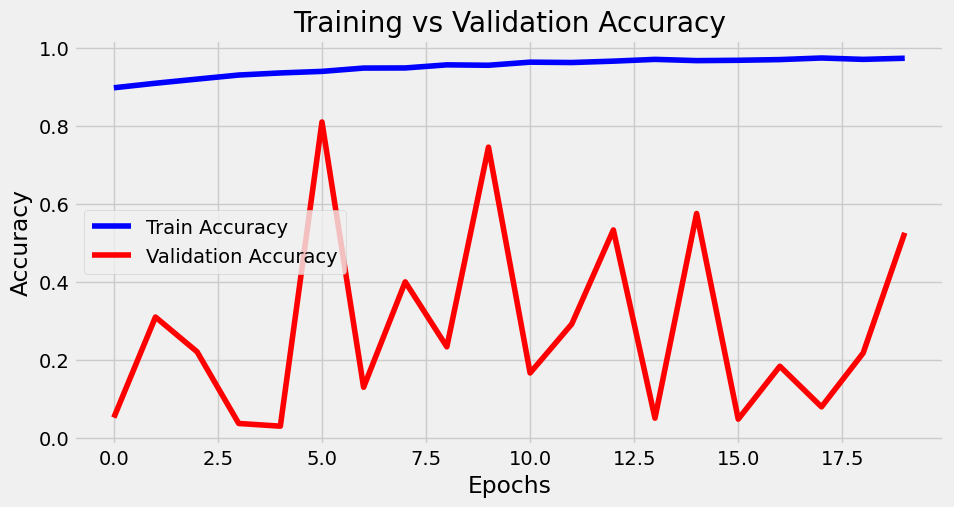

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot Precision, Recall, and F1-score
df_report[:-3].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.title('Classification Report')
plt.xticks(rotation=45)
plt.show()


NameError: name 'y_true' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


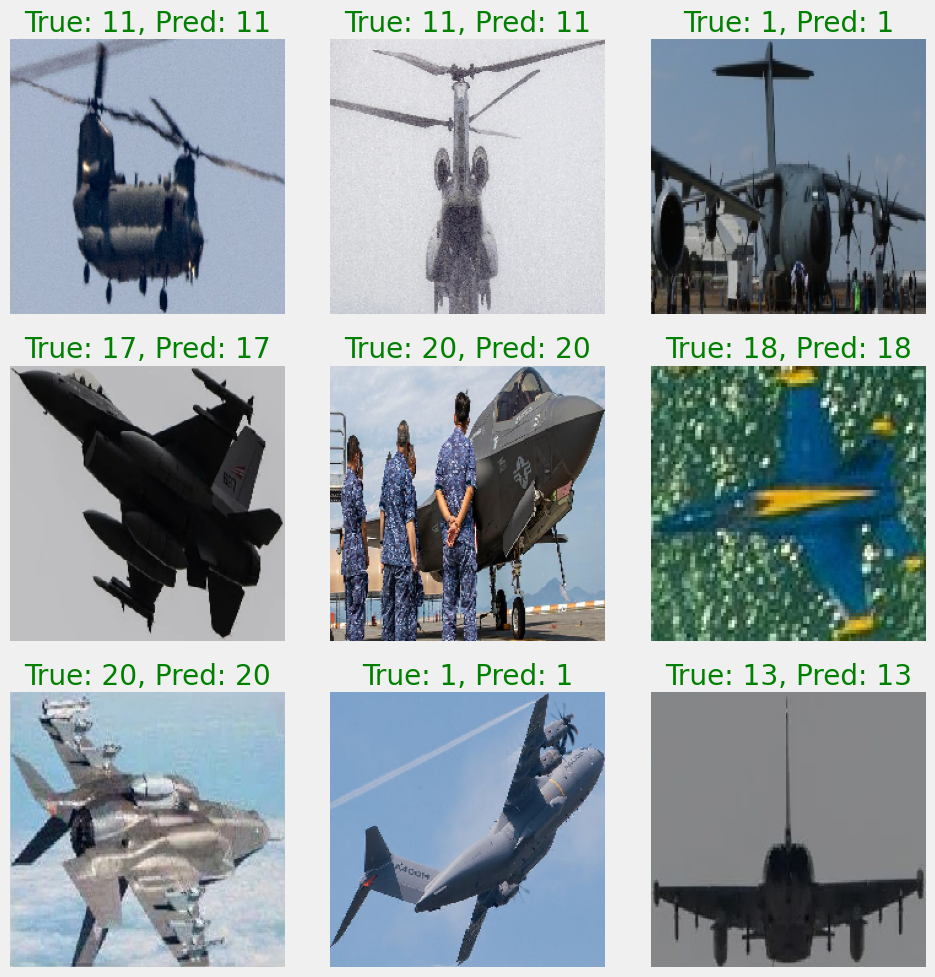

In [22]:
import random
from tensorflow.keras.preprocessing import image

# Get some test images
sample_images, sample_labels = next(test_gen)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = sample_images[i]
    true_label = np.argmax(sample_labels[i])
    pred_label = np.argmax(model.predict(img[np.newaxis, ...]))

    ax.imshow(img)
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color='green' if true_label == pred_label else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.save("model.keras")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,389,522 (127.37 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,199,432 (84.68 MB)

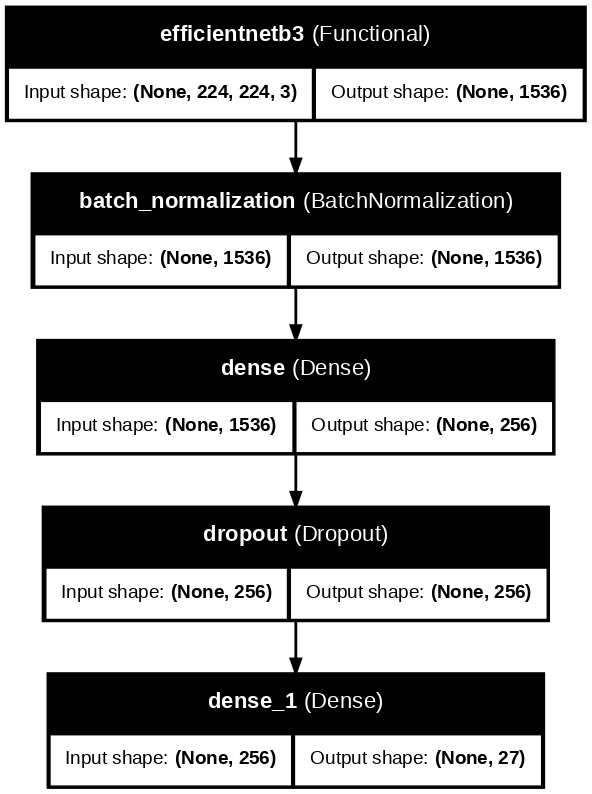

In [23]:
from tensorflow.keras.utils import plot_model  # Updated import for TensorFlow 2.x

# Display model summary
model.summary()

# Save and display model architecture with shapes
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=100)

# (Optional) Display the saved model image inline if using Jupyter Notebook
from IPython.display import Image
Image("model.png")
